# Purpose
- first in Parallel beam
    - implement projection onto subspace of basis functions
    - test extrapolation based on finding basis coefficients
    - test extrapolation based on projection onto convex sets
- all of this generalises to arbitrary sampling (need to think about jacobian for projection - but should work)

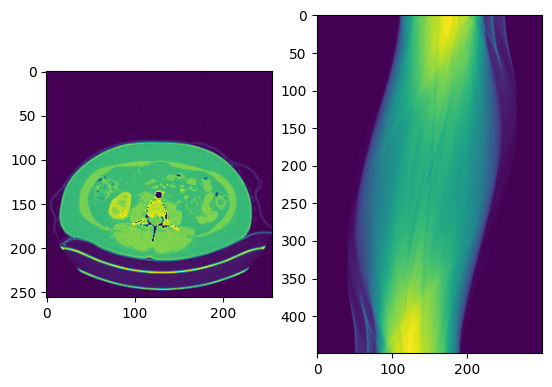

In [13]:
import sys
import os
from pathlib import Path
ROOT_FOLDER = Path(os.path.abspath("../../.."))
SRC = ROOT_FOLDER / "src"
if not SRC in sys.path:
    sys.path.append(SRC)

import torch
import numpy as np
import time
import odl.contrib.torch as odl_torch
import matplotlib.pyplot as plt

from utils.geometry import ParallelGeometry, DEVICE
from models.analyticmodels import RamLak

g = ParallelGeometry(1.0, 450, 300)
ray_l = odl_torch.OperatorModule(g.ray)
bp_l = odl_torch.OperatorModule(g.BP)

kits_data = torch.load(ROOT_FOLDER / "data/kits_phantoms_256.pt")[:500, 1, :, :].to(DEVICE)
# htc_data = torch.stack(torch.load(ROOT_FOLDER / "data/HTC2022/HTCTrainingPhantoms.pt")).to(DEVICE)

kits_sinos = ray_l(kits_data)

plt.subplot(121)
plt.imshow(kits_data[0].cpu())
plt.subplot(122)
plt.imshow(kits_sinos[0].cpu())
plt.show()

67.41023135185242 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([5050, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
13.83452320098877 s to take inner products
3.141767978668213 s to sum basis functions
projection MSE tensor(0.0002)


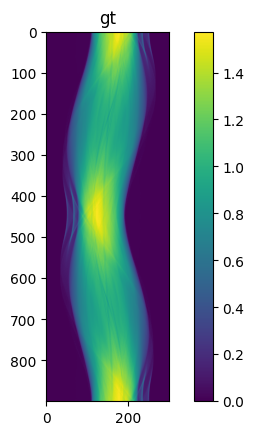

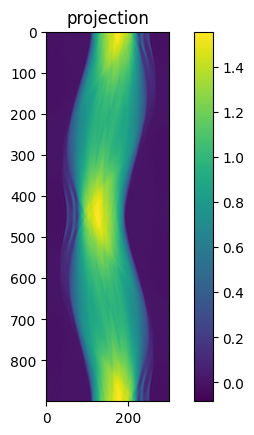

In [45]:
#projecting on subspace
ss = torch.from_numpy(g.translations / g.rho).to(DEVICE, dtype=torch.float32)
phis = torch.concat([g.tangles, g.tangles + torch.pi]).to(DEVICE, dtype=torch.float32)

def get_Un_sink(n: int, k: int, phis: torch.Tensor, ss: torch.Tensor):    
    assert k > 0 and k <= n
    phis, ss = phis[:, None], ss[None]
    return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * torch.sin(k*phis)
def get_Un_cosk(n: int, k: int, phis: torch.Tensor, ss: torch.Tensor):
    assert k >= 0 and k <= n
    phis, ss = phis[:, None], ss[None]
    if k == 0:
        return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * (phis*0+1/np.sqrt(2.0))
    return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * torch.cos(k*phis)

def hlcc_range(N: int, skipe_zero_k):
    n = 0
    while n < N:
        k = n % 2
        while k <= n:
            if skipe_zero_k and k == 0:
                k += 2
                continue
            yield (n, k)
            k += 2
        n += 1

def project(sinos: torch.Tensor, phis: torch.Tensor, ss: torch.Tensor, udeg = 50):
    a = time.time()
    ds, dphi = torch.mean(ss[1:] -ss[:-1]), torch.mean(phis[1:] - phis[:-1])
    W = torch.sqrt(1 - ss**2)
    #This might be faster to implement in a loop. Creating this matrix is very slow when udeg is large
    P = torch.stack([
        get_Un_cosk(n, k, phis, ss) for n, k in hlcc_range(udeg, skipe_zero_k=False)
    ] + [
        get_Un_sink(n, k, phis, ss) for n, k in hlcc_range(udeg, skipe_zero_k=True)
    ])
    print(time.time()-a, "s to create P")
    a = time.time()
    proj_coeffs = torch.einsum("bps,dps->db", P*W, sinos)*ds*dphi
    print(time.time()-a, "s to take inner products")
    a = time.time()
    proj_sinos = 2/(torch.pi**2) * torch.einsum("bps,db->dps", P, proj_coeffs)
    print(time.time()-a, "s to sum basis functions")
    return proj_sinos

double_range_sinos = torch.concat([kits_sinos, torch.flip(kits_sinos, dims=(-1,))], dim=1)[:10]

proj_sinos = project(double_range_sinos, phis, ss, udeg=70)

print("projection MSE", torch.mean((proj_sinos-double_range_sinos)**2))

plt.imshow(double_range_sinos[0].cpu())
plt.title("gt")
plt.colorbar()
plt.show()
plt.imshow(proj_sinos[0].cpu())
plt.title("projection")
plt.colorbar()
plt.show()


mse between recons tensor(0.0058)
mse recon_orig tensor(0.0015)
mse recon_proj tensor(0.0094)


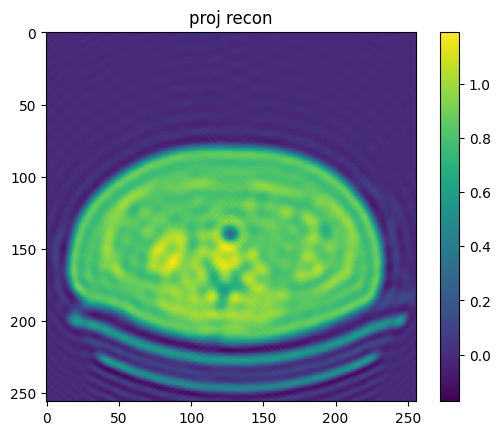

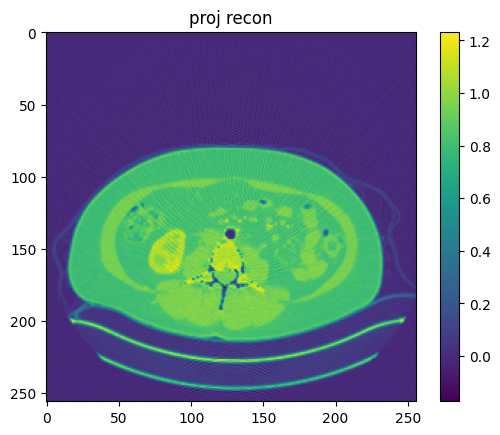

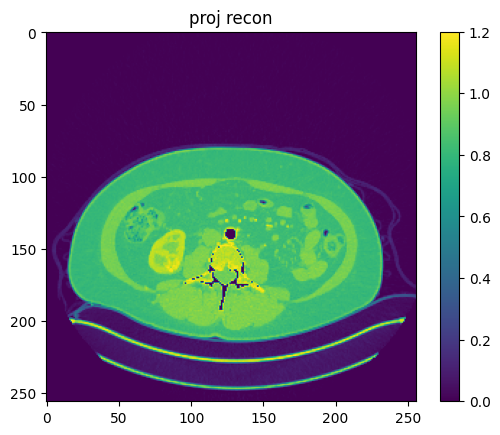

In [47]:
#evaluation of projected reconstructions

ramlak = RamLak(g)
mse_fn = lambda diff : torch.mean(diff**2)

recons_orig = ramlak(kits_sinos[:10])
recons_proj = ramlak(proj_sinos[:, :450])

print("mse between recons", mse_fn(recons_orig-recons_proj))
print("mse recon_orig", mse_fn(recons_orig-kits_data[:10]))
print("mse recon_proj", mse_fn(recons_proj-kits_data[:10]))

plt.imshow(recons_proj[0].cpu())
plt.title("proj recon")
plt.colorbar()
plt.show()
plt.imshow(recons_orig[0].cpu())
plt.title("orig recon")
plt.colorbar()
plt.show()
plt.imshow(kits_data[0].cpu())
plt.title("gt")
plt.colorbar()
plt.show()

### Below is an iterative Sinogram Extrapolatin method that can be interpreted as a Projection Onto Convex Sets  (POC) method

0.15337538719177246 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07493352890014648 s to take inner products
0.06666040420532227 s to sum basis functions
iteration 1 mse: tensor(0.1835)


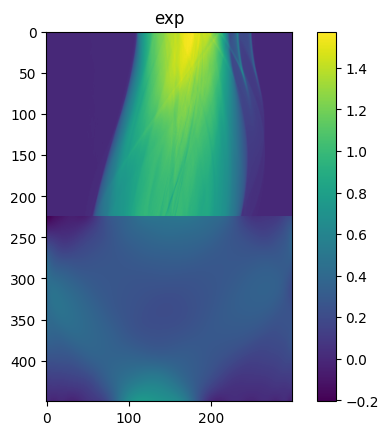

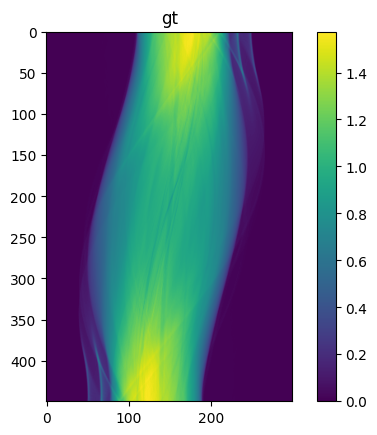

0.148240327835083 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.06637382507324219 s to take inner products
0.07597184181213379 s to sum basis functions
iteration 2 mse: tensor(0.1348)


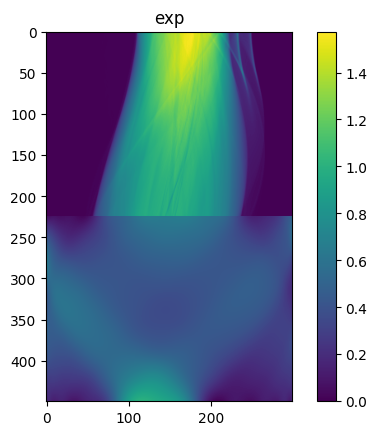

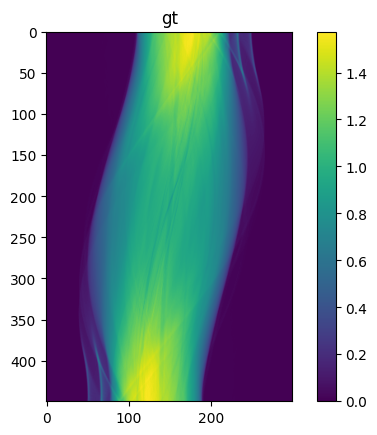

0.14208650588989258 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.0751352310180664 s to take inner products
0.08325505256652832 s to sum basis functions
iteration 3 mse: tensor(0.1195)


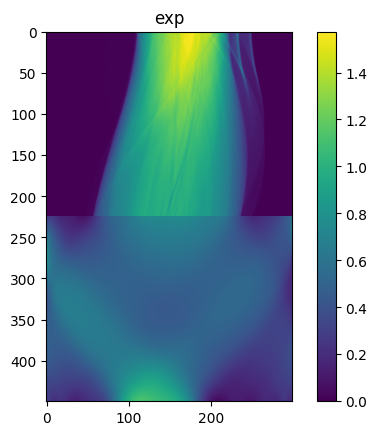

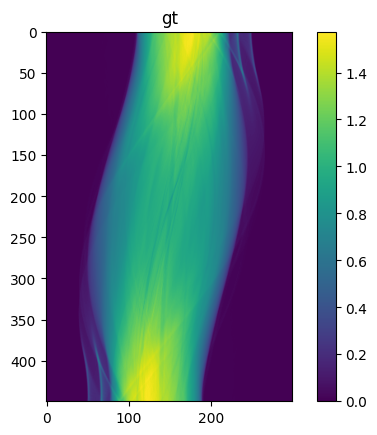

0.2016749382019043 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07522082328796387 s to take inner products
0.07173967361450195 s to sum basis functions
iteration 4 mse: tensor(0.1106)


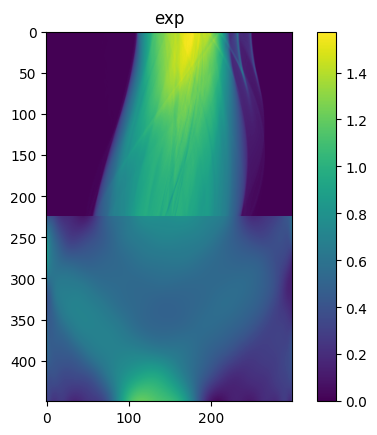

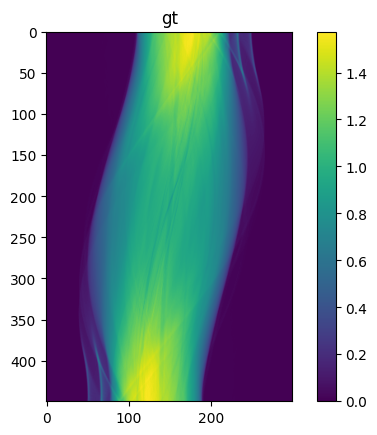

0.14140963554382324 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07406258583068848 s to take inner products
0.0875997543334961 s to sum basis functions
iteration 5 mse: tensor(0.1027)


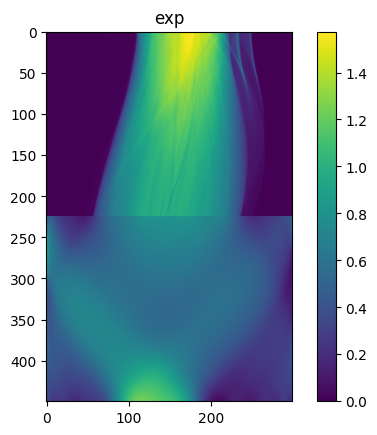

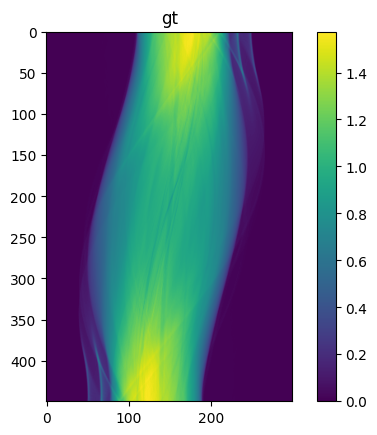

0.14551496505737305 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07330703735351562 s to take inner products
0.08196282386779785 s to sum basis functions
iteration 6 mse: tensor(0.0952)


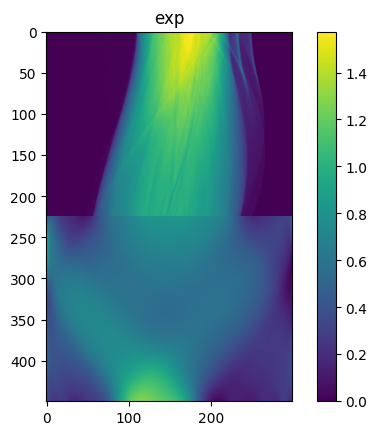

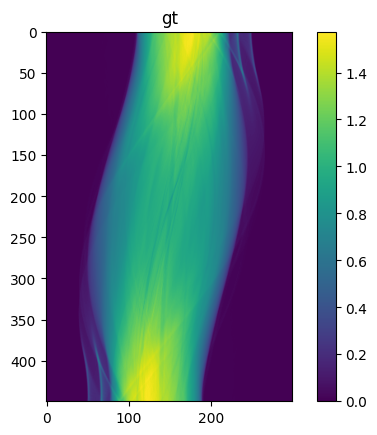

0.18172001838684082 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07459616661071777 s to take inner products
0.08313679695129395 s to sum basis functions
iteration 7 mse: tensor(0.0882)


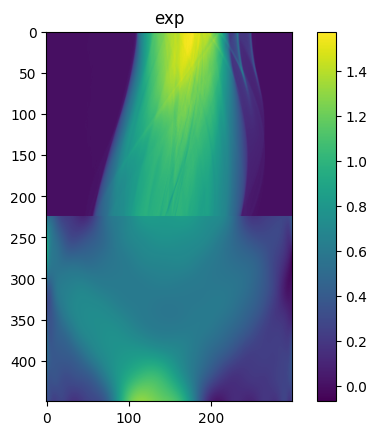

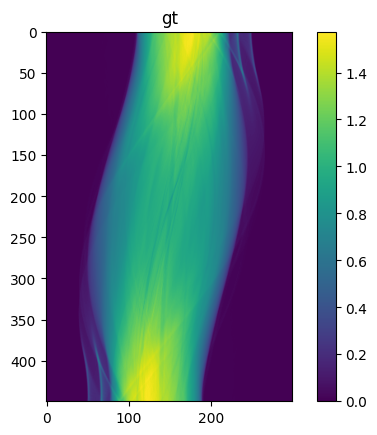

0.14390182495117188 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07593750953674316 s to take inner products
0.0910041332244873 s to sum basis functions
iteration 8 mse: tensor(0.0817)


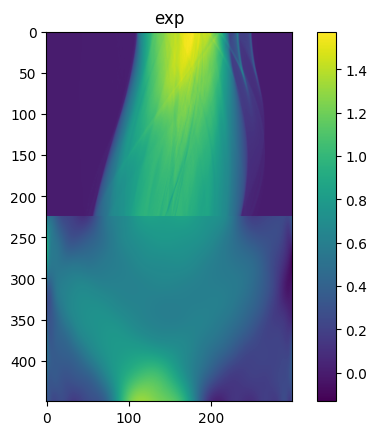

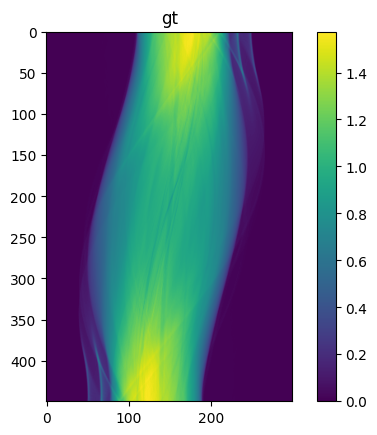

0.14687299728393555 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08328890800476074 s to take inner products
0.12021517753601074 s to sum basis functions
iteration 9 mse: tensor(0.0758)


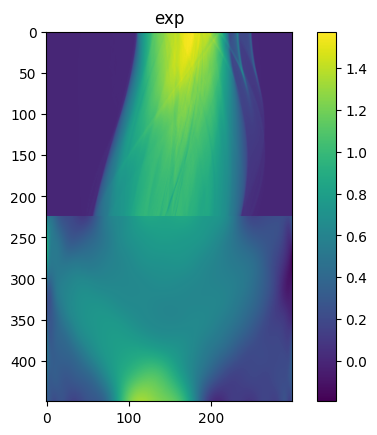

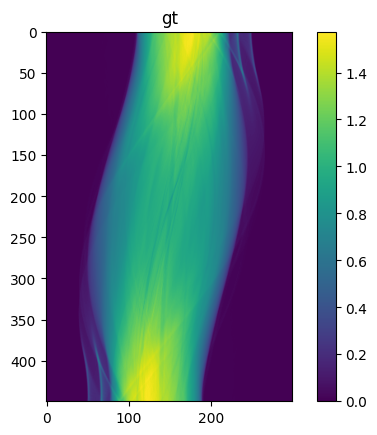

0.1652052402496338 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07933783531188965 s to take inner products
0.08406400680541992 s to sum basis functions
iteration 10 mse: tensor(0.0704)


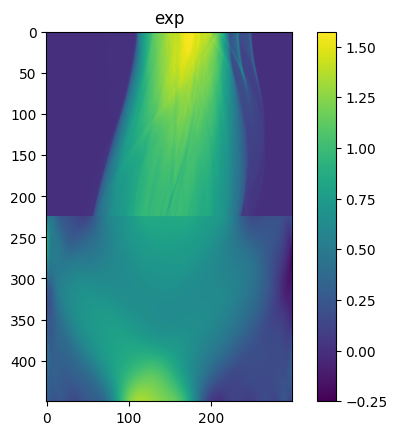

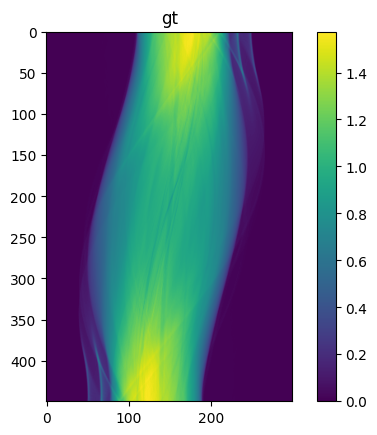

0.17993402481079102 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08553528785705566 s to take inner products
0.08308792114257812 s to sum basis functions
iteration 11 mse: tensor(0.0656)


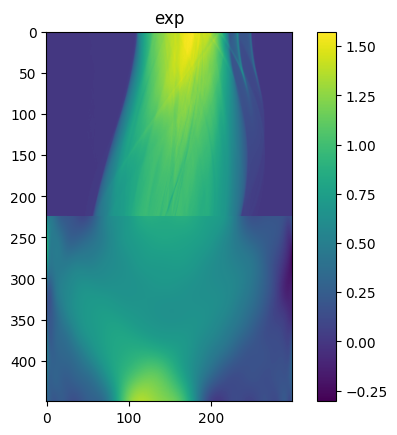

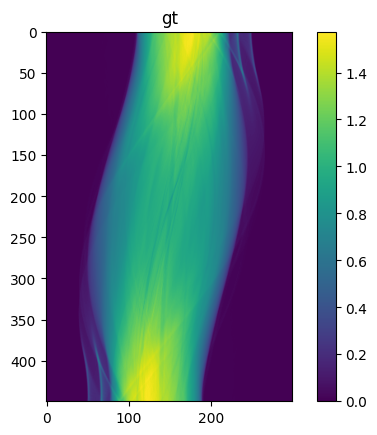

0.14794707298278809 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07683038711547852 s to take inner products
0.08685541152954102 s to sum basis functions
iteration 12 mse: tensor(0.0612)


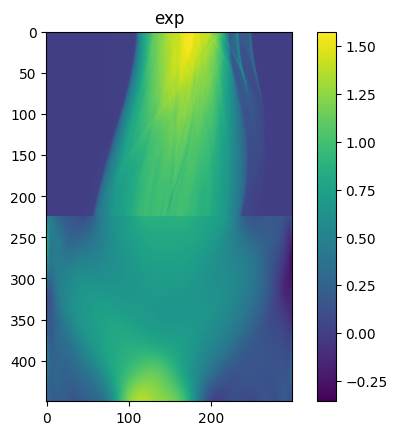

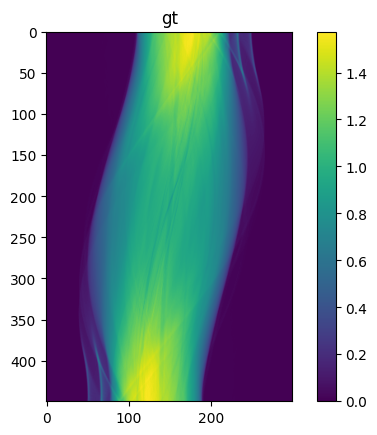

0.14852333068847656 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.06955170631408691 s to take inner products
0.08940839767456055 s to sum basis functions
iteration 13 mse: tensor(0.0573)


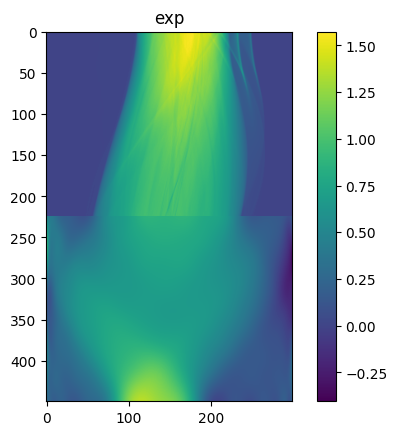

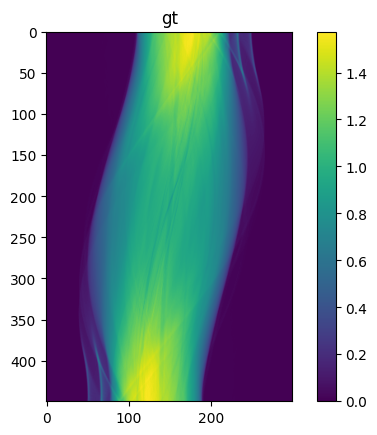

0.1621382236480713 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08355903625488281 s to take inner products
0.09787559509277344 s to sum basis functions
iteration 14 mse: tensor(0.0539)


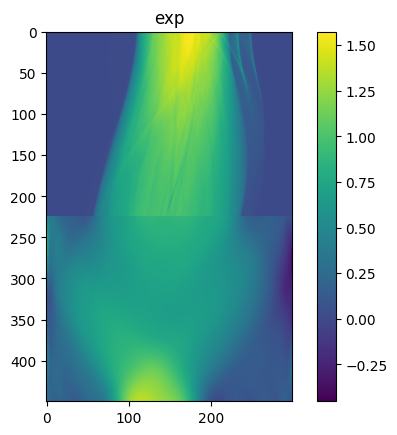

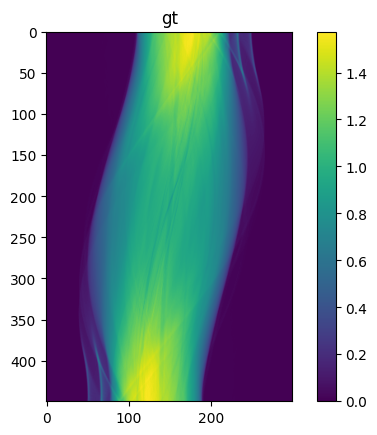

0.16057968139648438 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07593631744384766 s to take inner products
0.09200072288513184 s to sum basis functions
iteration 15 mse: tensor(0.0507)


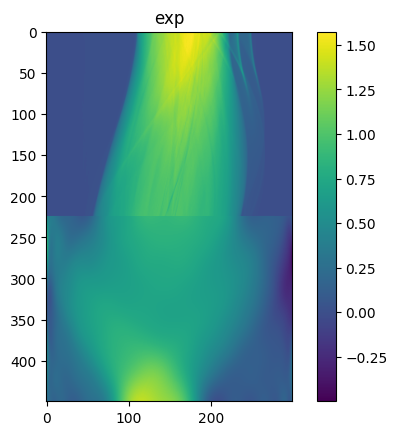

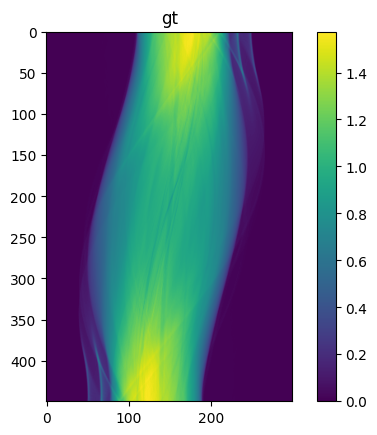

0.19930291175842285 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08159255981445312 s to take inner products
0.09428620338439941 s to sum basis functions
iteration 16 mse: tensor(0.0479)


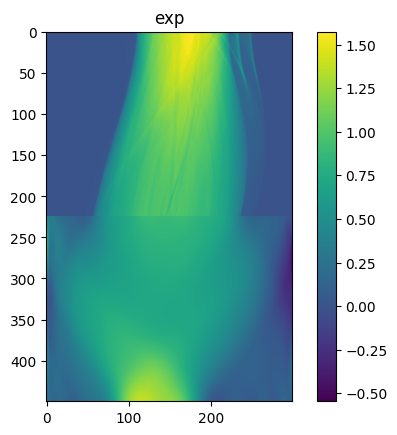

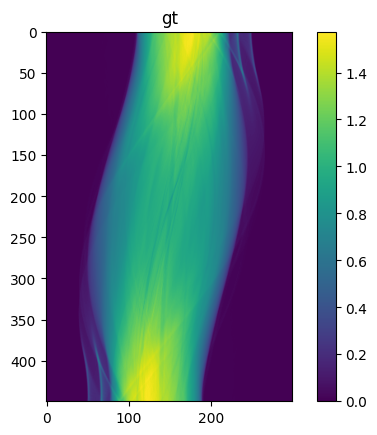

0.1457653045654297 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07913064956665039 s to take inner products
0.07768082618713379 s to sum basis functions
iteration 17 mse: tensor(0.0454)


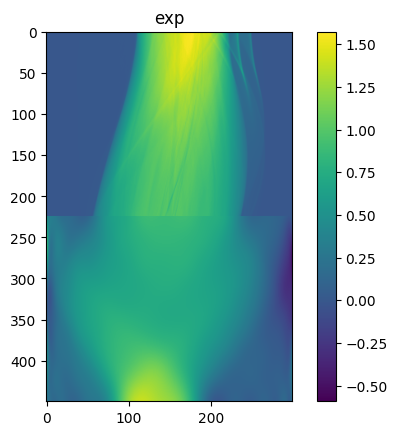

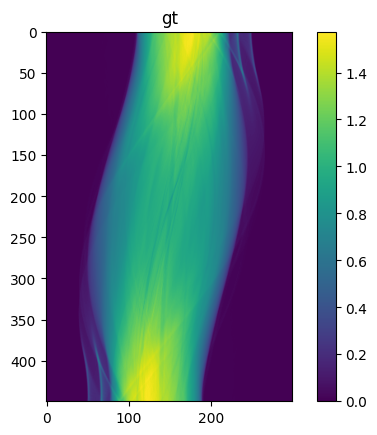

0.15854477882385254 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08021426200866699 s to take inner products
0.07738637924194336 s to sum basis functions
iteration 18 mse: tensor(0.0432)


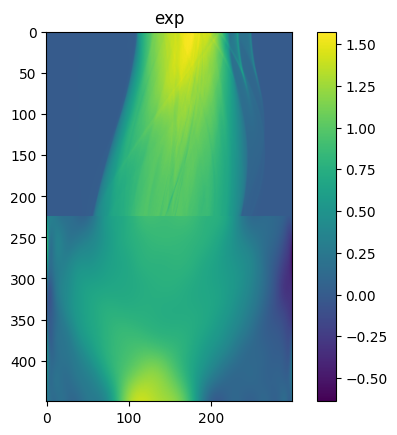

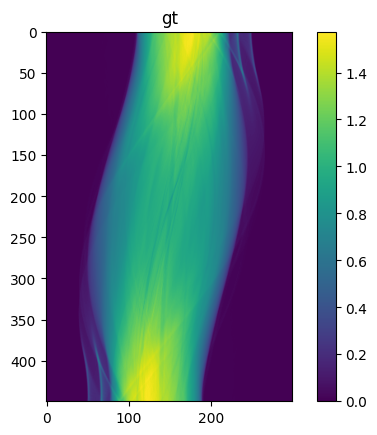

0.16652560234069824 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08263564109802246 s to take inner products
0.09461688995361328 s to sum basis functions
iteration 19 mse: tensor(0.0413)


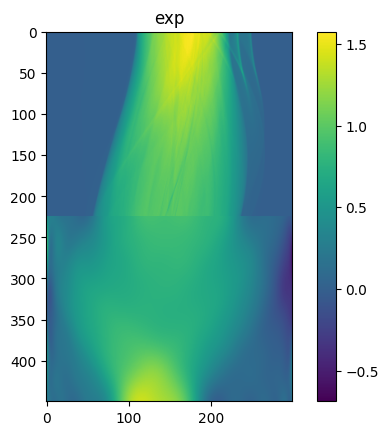

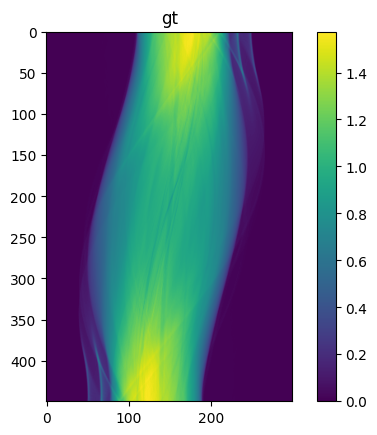

0.2072615623474121 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08032560348510742 s to take inner products
0.08606433868408203 s to sum basis functions
iteration 20 mse: tensor(0.0395)


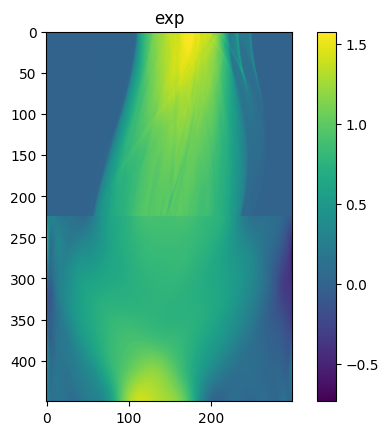

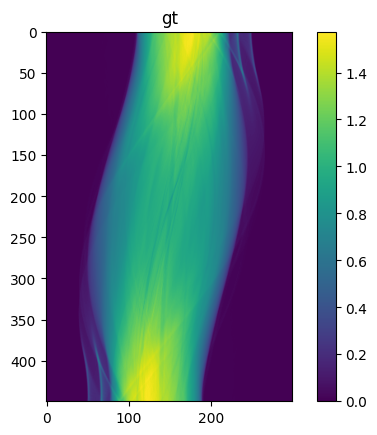

0.17421770095825195 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08317732810974121 s to take inner products
0.08913111686706543 s to sum basis functions
iteration 21 mse: tensor(0.0380)


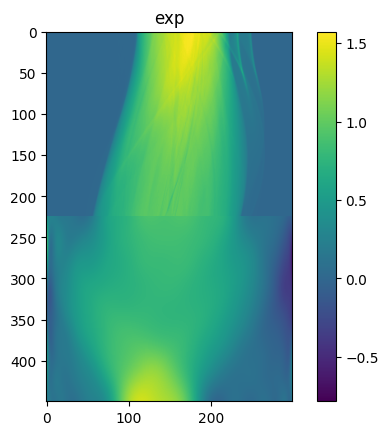

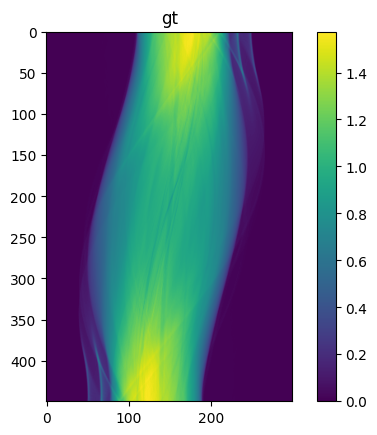

0.17258691787719727 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08149051666259766 s to take inner products
0.08785128593444824 s to sum basis functions
iteration 22 mse: tensor(0.0367)


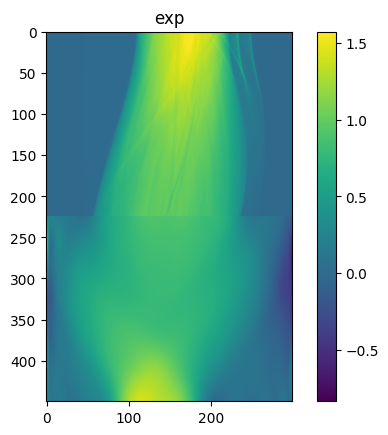

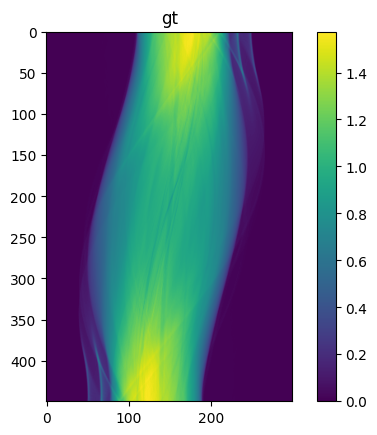

0.1882624626159668 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08513307571411133 s to take inner products
0.08215212821960449 s to sum basis functions
iteration 23 mse: tensor(0.0355)


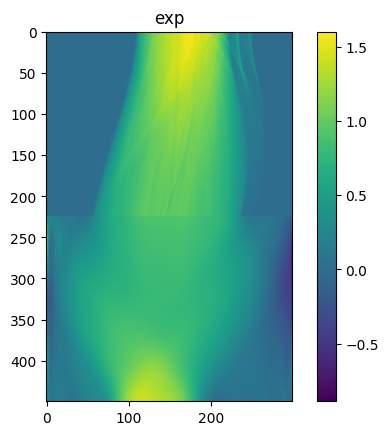

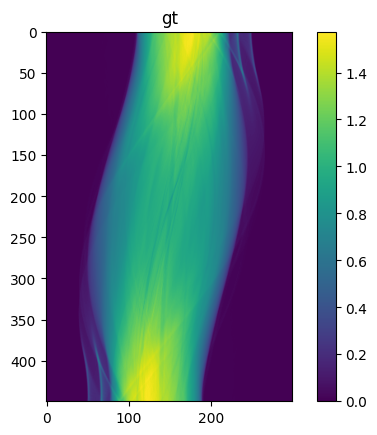

0.16677045822143555 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08614945411682129 s to take inner products
0.0894474983215332 s to sum basis functions
iteration 24 mse: tensor(0.0345)


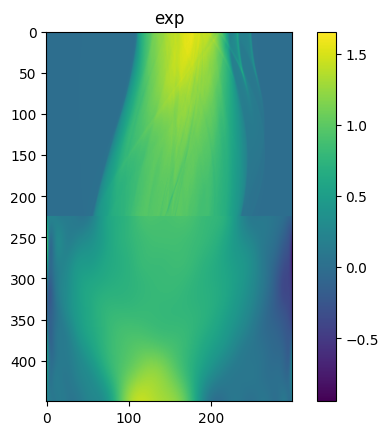

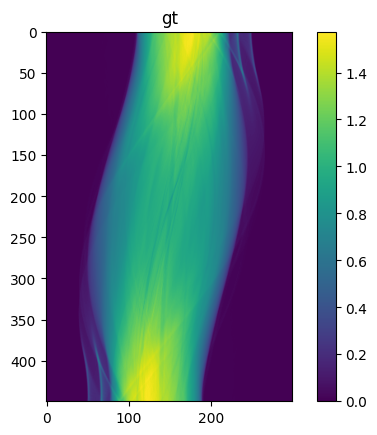

0.1723461151123047 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08582854270935059 s to take inner products
0.10430550575256348 s to sum basis functions
iteration 25 mse: tensor(0.0337)


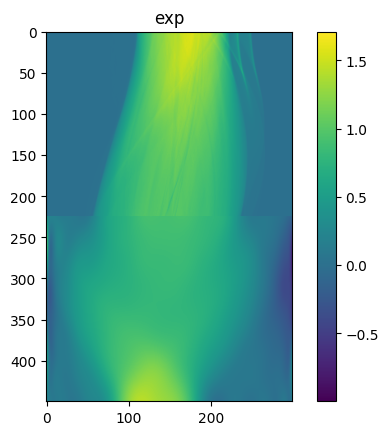

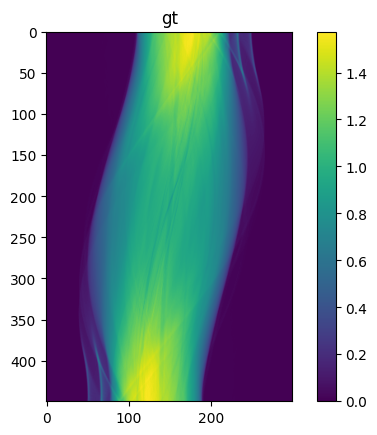

0.1721358299255371 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08411455154418945 s to take inner products
0.09144020080566406 s to sum basis functions
iteration 26 mse: tensor(0.0330)


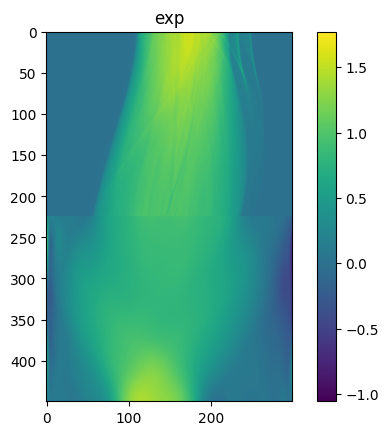

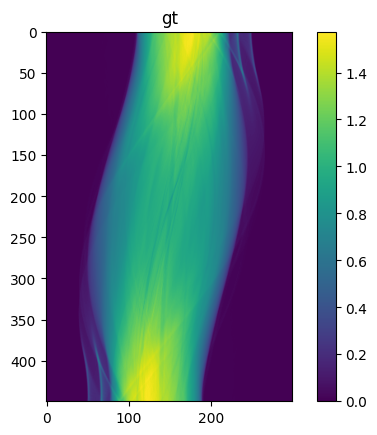

0.18361854553222656 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.08128619194030762 s to take inner products
0.0901951789855957 s to sum basis functions
iteration 27 mse: tensor(0.0325)


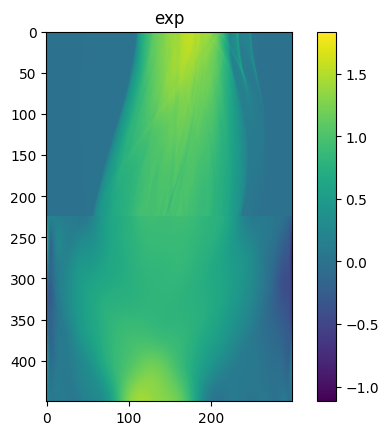

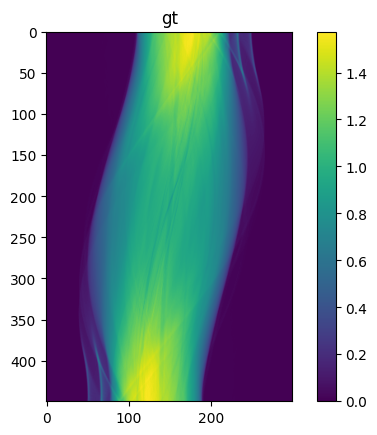

0.14756250381469727 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07216358184814453 s to take inner products
0.08852052688598633 s to sum basis functions
iteration 28 mse: tensor(0.0321)


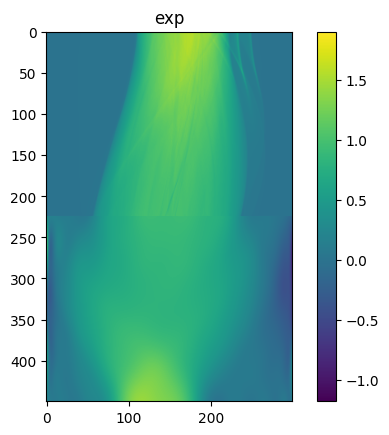

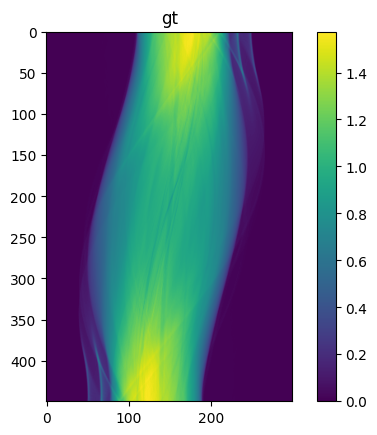

0.18781638145446777 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.0855104923248291 s to take inner products
0.10051941871643066 s to sum basis functions
iteration 29 mse: tensor(0.0318)


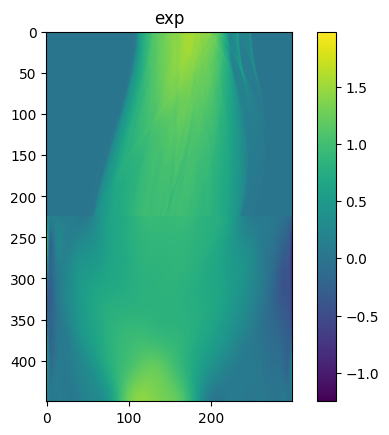

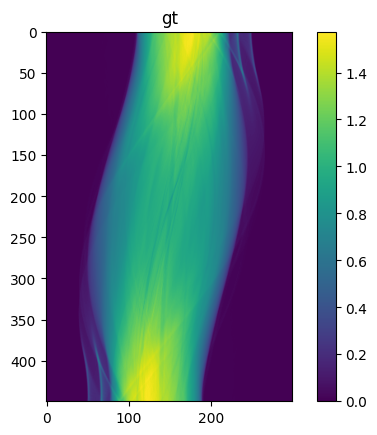

0.15970158576965332 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([210, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.07930541038513184 s to take inner products
0.08765411376953125 s to sum basis functions
iteration 30 mse: tensor(0.0316)


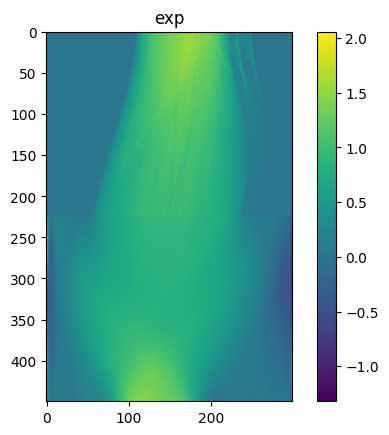

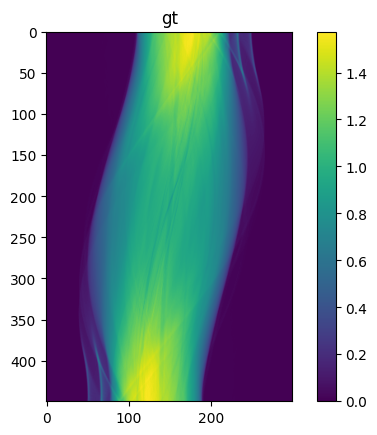

In [56]:
#Attempt for iterative analytic sinogram extrapolation based on HLCC

half_sinos = kits_sinos[:10] * 1
half_sinos[:, 225:, :] = 0

exp_sinos = half_sinos*1
for it in range(30):
    proj_sinos = project(torch.concat([exp_sinos, torch.flip(exp_sinos, dims=(-1,))], dim=1), phis, ss, 20)
    exp_sinos[:, 225:, :] = proj_sinos[:, 225:450, :]

    print("="*40)
    print("iteration", it+1, "mse:", mse_fn(exp_sinos-kits_sinos[:10]))
    plt.imshow(exp_sinos[0].cpu())
    plt.title("exp")
    plt.colorbar()
    plt.show()
    plt.imshow(kits_sinos[0].cpu())
    plt.title("gt")
    plt.colorbar()
    plt.show()
    print("="*40)